<a href="https://colab.research.google.com/github/sterini/nilm-eval/blob/master/Copy_of_FL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Communication-Aware Clustered FederatedLearning: How to Leverage Data Heterogeneity

- Import modules contains imported modules, seeds for random computations and TPU configuration
- Methods, objects and models contains all the methods to manage the datasets, create the users-clusters setup, initialize CNNs and NICEs and plot the results
- System and data initialization initialize users, clusters, data for each of them...
ALL of the previous sections must be executed!
- CNN Training contains CNN training method and computation of local accuracy
- NICE Training contains NICE training method
- Test section contains a method to evaluate global performances of the model that average the predictions (without estimated marginals), the model with the marginals, and other ideas...

# Import modules

In [ ]:
from matplotlib import pyplot as plt
import random as rnd
import numpy as np
import collections
import os

# tf and keras
import tensorflow as tf
from keras.datasets import cifar10
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

# pytorch
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.distributions import Distribution, Uniform

tf.random.set_seed(42)
np.random.seed(42)
rnd.seed(42)
torch.manual_seed(42)

# for tensorflow warnings!
import logging
tf.get_logger().setLevel(logging.ERROR)

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Methods, objects and models

In [ ]:
class cluster:
    def __init__(self, number):
        self.users = []
        self.number = number
    def number_of_users(self):
        return len(self.users)
    def add_user(self, user):
        self.users.append(user)
    def set_train_data(self, train_data):
        self.train_data = train_data
    def set_test_data(self, test_data):
        self.test_data = test_data
    def set_model(self, model):
        self.model = model
    def set_estimation(self, estimation):
        self.estimation = estimation
        
class user_information:
    def __init__(self, name, cluster):
        self.name = name
        self.cluster = cluster
    def set_data(self, data):
        self.data = data
    def set_accuracy(self, accuracy):
        self.accuracy = accuracy
    def get_accuracy(self):
        return self.accuracy
    def set_model(self, model):
        self.model = model
    def get_model(self):
        return self.model
    def set_estimation(self, estimation):
        self.estimation = estimation
    def get_estimation(self):
        return self.estimation
    def model_size(self):
        return number_of_parameters(self.get_model().get_weights())
    def buffer_size(self):
        return self.model_size()+self.estimation_size()

In [ ]:
classes = {
    0 : "airplane",
    1 : "automobile",
    2 : "bird",
    3 : "cat",
    4 : "deer",
    5 : "dog",
    6 : "frog",
    7 : "horse",
    8 : "ship",
    9 : "truck",
}

In [ ]:
def load_preprocessed_cifar10_ds():
    (X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
    num_classes = len(classes)
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0
    Y_train = to_categorical(Y_train, num_classes)
    Y_test = to_categorical(Y_test, num_classes)
    return X_train, Y_train, X_test, Y_test

In [ ]:
def create_dictionary_from_dataset(dataset):
    division = collections.defaultdict(list)
    for v, k in dataset:
        label = int(np.argmax(k))
        division[label].append(v)
    return division

In [ ]:
def assign_users_to_clusters_randomly(users_ids, number_of_clusters):
    tmp_ids = users_ids
    number_of_users = len(tmp_ids)
    users_per_cluster = int(number_of_users/number_of_clusters)
    clusters = []
    for i in range(number_of_clusters):
        tmp_cluster = cluster(number=i)
        for _ in range(users_per_cluster):
            user = rnd.choices(tmp_ids)[0]
            tmp_ids.remove(user)
            tmp_user = user_information(user, i)
            tmp_cluster.add_user(tmp_user)
        clusters.append(tmp_cluster)
        print('Users in cluster', tmp_cluster.number, 'are:', [u.name for u in tmp_cluster.users])
        del tmp_cluster
    return clusters

In [ ]:
def ds_division(X, division, heterogeneity_factor, number_of_clusters, fav_classes):
    remaining_weights = (1-heterogeneity_factor)/9
    cluster_img = int(len(X)/number_of_clusters)
    cluster_ds = collections.OrderedDict()
    for i in range(number_of_clusters):
        fav_class = fav_classes[i]
        classes_weights = [remaining_weights for _ in classes]
        classes_weights[fav_class] = heterogeneity_factor
        cluster_X = np.zeros((cluster_img, 32, 32, 3))
        cluster_Y = np.zeros((cluster_img, 10))
        for j in range(cluster_img):
            chosen_class = rnd.choices(list(range(10)), classes_weights)[0] # because it is a 1-dimensional vector
            images_from_class = division[chosen_class]
            chosen_image = images_from_class[np.random.randint(0, len(images_from_class))]
            cluster_X[j] = chosen_image
            cluster_Y[j] = to_categorical(chosen_class, len(classes))
        cluster_ds[i] = collections.OrderedDict((('labels', cluster_Y), ('images', cluster_X)))
    return cluster_ds

In [ ]:
class define_model():
    def __init__(self):
        self.model = Sequential()
        self.model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
        self.model.add(BatchNormalization())
        self.model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling2D((2, 2)))
        self.model.add(Dropout(0.2)) 
        self.model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        self.model.add(BatchNormalization())
        self.model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling2D((2, 2)))
        self.model.add(Dropout(0.3))
        self.model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        self.model.add(BatchNormalization())
        self.model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling2D((2, 2)))
        self.model.add(Dropout(0.4))
        self.model.add(Flatten())
        self.model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.5))
        self.model.add(Dense(10, activation='softmax'))
        opt = Adam(lr=0.001)
        self.model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
class CouplingLayer(nn.Module):
  def __init__(self, data_dim, hidden_dim, mask, num_layers=3):
    super().__init__()

    assert data_dim % 2 == 0

    self.mask = mask

    modules = [nn.Linear(data_dim, hidden_dim), nn.LeakyReLU(0.2)]
    for i in range(num_layers - 2):
      modules.append(nn.Linear(hidden_dim, hidden_dim))
      modules.append(nn.LeakyReLU(0.2))
    modules.append(nn.Linear(hidden_dim, data_dim))

    self.m = nn.Sequential(*modules)

  def forward(self, x, logdet, invert=False):
    if not invert:
      x1, x2 = self.mask * x, (1. - self.mask) * x
      y1, y2 = x1, x2 + (self.m(x1) * (1. - self.mask))
      return y1 + y2, logdet

    # Inverse additive coupling layer
    y1, y2 = self.mask * x, (1. - self.mask) * x
    x1, x2 = y1, y2 - (self.m(y1) * (1. - self.mask))
    return x1 + x2, logdet

class ScalingLayer(nn.Module):
  
  def __init__(self, data_dim):
    super().__init__()
    self.log_scale_vector = nn.Parameter(torch.randn(1, data_dim, requires_grad=True))

  def forward(self, x, logdet, invert=False):
    log_det_jacobian = torch.sum(self.log_scale_vector)

    if invert:
        return torch.exp(- self.log_scale_vector) * x, logdet - log_det_jacobian

    return torch.exp(self.log_scale_vector) * x, logdet + log_det_jacobian

class LogisticDistribution(Distribution):
    def __init__(self):
        super().__init__()

    def log_prob(self, x):
        return -(F.softplus(x) + F.softplus(-x))
    
    def prob(self, x):
        return torch.exp(torch.sum(self.log_prob(x)))

    def sample(self, size):
        z = Uniform(torch.FloatTensor([0.]), torch.FloatTensor([1.])).sample(size)
        return torch.log(z) - torch.log(1. - z)
    
class NICE(nn.Module):
  def __init__(self, data_dim, num_coupling_layers=3):
    super().__init__()

    self.data_dim = data_dim

    # alternating mask orientations for consecutive coupling layers
    masks = [self._get_mask(data_dim, orientation=(i % 2 == 0)) for i in range(num_coupling_layers)]

    self.coupling_layers = nn.ModuleList([CouplingLayer(
        data_dim=data_dim, 
        hidden_dim=30, # avevo provato con 100 e nel paper ne mettono 200!
        mask=masks[i], 
        num_layers=3)
        for i in range(num_coupling_layers)])

    self.scaling_layer = ScalingLayer(data_dim=data_dim)
    self.prior = LogisticDistribution()

  def forward(self, x, invert=False):
    if not invert:
      z, log_det_jacobian = self.f(x)
      log_likelihood = torch.sum(self.prior.log_prob(z), dim=1) + log_det_jacobian
      return z, log_likelihood

    return self.f_inverse(x)

  def f(self, x):
    z = x
    log_det_jacobian = 0
    for i, coupling_layer in enumerate(self.coupling_layers):
      z, log_det_jacobian = coupling_layer(z, log_det_jacobian)
    z, log_det_jacobian = self.scaling_layer(z, log_det_jacobian)
    return z, log_det_jacobian

  def f_inverse(self, z):
    x = z
    x, _ = self.scaling_layer(x, 0, invert=True)
    for i, coupling_layer in reversed(list(enumerate(self.coupling_layers))):
      x, _ = coupling_layer(x, 0, invert=True)
    return x

  def sample(self, num_samples):
    z = self.prior.sample([num_samples, self.data_dim]).view(num_samples, self.data_dim)
    print(z)
    return self.f_inverse(z)

  def _get_mask(self, dim, orientation=True):
    mask = np.zeros(dim)
    mask[::2] = 1.
    if orientation:
      mask = 1. - mask # flip mask orientation
    mask = torch.tensor(mask)
    return mask.float()

In [ ]:
def top_k_sparsificate_model_weights_tf(weights, fraction):
    tmp_list = []
    for el in weights:
        lay_list = el.reshape((-1)).tolist()
        tmp_list = tmp_list + [abs(el) for el in lay_list]
    tmp_list.sort(reverse=True)
    k_th_element = tmp_list[int(fraction*552874)-1] # 552874 is the number of parameters of the CNNs!
    new_weights = []
    for el in weights:
        original_shape = el.shape
        reshaped_el = el.reshape((-1))
        for i in range(len(reshaped_el)):
            if abs(reshaped_el[i]) < k_th_element:
                reshaped_el[i] = 0.0
        new_weights.append(reshaped_el.reshape(original_shape))
    return new_weights

In [ ]:
def initialize_models(clusters, server, fraction):
    w = top_k_sparsificate_model_weights_tf(server.model.get_weights(), fraction)
    for cluster in clusters:
        tmp_cluster_model = define_model() # these steps are in order to create one model for each cluster and user, instead of the same model shared among all
        tmp_cluster_model.model.set_weights(w)
        cluster.set_model(tmp_cluster_model.model)
        del tmp_cluster_model
        cluster.set_model(server.model) # maybe useless
        # estimation
        tmp_cluster_estimation_model = NICE(data_dim=3072, num_coupling_layers=3)
        cluster.set_estimation(tmp_cluster_estimation_model)
        for user in cluster.users:
            # model
            tmp_user_model = define_model()
            tmp_user_model.model.set_weights(cluster.model.get_weights())
            user.set_model(tmp_user_model.model)
            del tmp_user_model
            # estimation
            tmp_user_estimation_model = NICE(data_dim=3072, num_coupling_layers=3)
            tmp_user_estimation_model.load_state_dict(cluster.estimation.state_dict())
            user.set_estimation(tmp_user_estimation_model)
            del tmp_user_estimation_model

In [ ]:
def transfer_cluster_model_to_users(cluster):
    for user in cluster.users:
        user.get_model().set_weights(cluster.model.get_weights())
        
def transfer_cluster_estimation_to_users(cluster):
    for user in cluster.users:
        user.get_estimation().load_state_dict(cluster.estimation.state_dict())

In [ ]:
def train_validation_split(X_train, Y_train):
    train_length = len(X_train)
    validation_length = int(train_length / 4)
    X_validation = X_train[:validation_length]
    X_train = X_train[validation_length:]
    Y_validation = Y_train[:validation_length]
    Y_train = Y_train[validation_length:]
    return X_train, Y_train, X_validation, Y_validation

In [ ]:
# all about sparsification for estimation model
def find_min_topk(list_of_resized_tensors, k):
    maxi_tensor = torch.cat(list_of_resized_tensors)
    topk = torch.topk(maxi_tensor, k, largest=True)[0]
    min_topk = torch.min(topk).numpy()
    return min_topk

def top_k_for_tensor(tensor, val):
    tensor = tensor.numpy()
    for i in range(tensor.shape[0]):
        if tensor[i] < val:
            tensor[i] = 0.0
    return torch.from_numpy(tensor)

def topk_sparsification_torch_load(load, percentage):
    k = int(0.01*percentage*568128)
    list_of_tensors = []
    for i in iter(load):
        list_of_tensors.append(load[i])
    list_of_resized_tensors = [t.reshape(-1) for t in list_of_tensors]
    min_topk = find_min_topk(list_of_resized_tensors, k)
    spars_t = []
    for t in list_of_resized_tensors:
        spars_t.append(top_k_for_tensor(t, min_topk))
    # inserisci nel dizionario
    j = 0
    for i in iter(load):
        load[i] = spars_t[j].view(load[i].shape)
        j += 1
    return load

# System and data initialization
1. update 16-th March: heterogeneity changed, removed a class for each cluster
2. update 14-th April: parameters changed (number of epochs, batch...) and data distribution changed (local dataset without a test set, server test set has no images in common with the clusters)

In [ ]:
number_of_users = 16
number_of_clusters = 4
bias_factor = 0.4

epochs = 20
estimation_epochs = 20 # ??
batch = 32 
estimation_batch = 32 # ?
iterations = 5 # 6 ?
# add if iteration == iterations-1: break in the training method

In [ ]:
classification_percentage = 50
estimation_percentage = 100

In [ ]:
users_ids = list(range(number_of_users))
print('Users ids list:', users_ids)
X_train, Y_train, X_test, Y_test = load_preprocessed_cifar10_ds()

division_train = create_dictionary_from_dataset(tf.data.Dataset.from_tensor_slices((X_train, Y_train)))
division_test = create_dictionary_from_dataset(tf.data.Dataset.from_tensor_slices((X_test, Y_test)))

clusters = assign_users_to_clusters_randomly(list(range(number_of_users)), number_of_clusters)
fav_classes = [np.random.randint(0, 10) for _ in range(number_of_clusters)] # to obtain the same heterogeneity for train and test datasets

print('')
for c in range(len(fav_classes)):
    print("Bias label of the cluster " + str(c) + " is " + str(fav_classes[c]) + ": " + str(classes[fav_classes[c]]))
# they must be [6, 3, 7, 4]

'''
# remove images of a specific class from each cluster
not_wanted_classes = []
while not len(not_wanted_classes) == 4:
    tmp_class = np.random.randint(0, 10)
    if not tmp_class == fav_classes[len(not_wanted_classes)]:
        not_wanted_classes.append(tmp_class)

print('')
for c in range(len(not_wanted_classes)):
    print("Missing image label of the cluster " + str(c) + " is " + str(not_wanted_classes[c]) + ": " + str(classes[not_wanted_classes[c]]))
# they must be [9, 2, 6, 7]
'''
# Clusters must be:
# Users in cluster 0 are: [10, 0, 4, 3]
# Users in cluster 1 are: [12, 11, 14, 1]
# Users in cluster 2 are: [7, 2, 6, 9]
# Users in cluster 3 are: [5, 8, 15, 13]

Users ids list: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
170500096/170498071 [==============================] - 2s 0us/step
Users in cluster 0 are: [10, 0, 4, 3]
Users in cluster 1 are: [12, 11, 14, 1]
Users in cluster 2 are: [7, 2, 6, 9]
Users in cluster 3 are: [5, 8, 15, 13]

Bias label of the cluster 0 is 6: frog
Bias label of the cluster 1 is 3: cat
Bias label of the cluster 2 is 7: horse
Bias label of the cluster 3 is 4: deer


'\n# remove images of a specific class from each cluster\nnot_wanted_classes = []\nwhile not len(not_wanted_classes) == 4:\n    tmp_class = np.random.randint(0, 10)\n    if not tmp_class == fav_classes[len(not_wanted_classes)]:\n        not_wanted_classes.append(tmp_class)\n\nprint(\'\')\nfor c in range(len(not_wanted_classes)):\n    print("Missing image label of the cluster " + str(c) + " is " + str(not_wanted_classes[c]) + ": " + str(classes[not_wanted_classes[c]]))\n# they must be [9, 2, 6, 7]\n'

In [ ]:
def new_dataset_division(X, division, heterogeneity_factor, number_of_clusters, fav_classes, not_wanted_classes):
    remaining_weights = (1-heterogeneity_factor)/8
    cluster_img = int(len(X)/number_of_clusters)
    cluster_ds = collections.OrderedDict()
    for i in range(number_of_clusters):
        not_wanted_class = not_wanted_classes[i]
        fav_class = fav_classes[i]
        classes_weights = [remaining_weights for _ in classes]
        classes_weights[fav_class] = heterogeneity_factor
        classes_weights[not_wanted_class] = 0
        cluster_X = np.zeros((cluster_img, 32, 32, 3))
        cluster_Y = np.zeros((cluster_img, 10))
        for j in range(cluster_img):
            chosen_class = rnd.choices(list(range(10)), classes_weights)[0] # because it is a 1-dimensional vector
            images_from_class = division[chosen_class]
            chosen_image = images_from_class[np.random.randint(0, len(images_from_class))]
            cluster_X[j] = chosen_image
            cluster_Y[j] = to_categorical(chosen_class, len(classes))
        cluster_ds[i] = collections.OrderedDict((('labels', cluster_Y), ('images', cluster_X)))
    return cluster_ds

In [ ]:
# old methods
clusters_train_datasets = ds_division(X_train, division_train, bias_factor, number_of_clusters, fav_classes)
clusters_test_datasets = ds_division(X_test, division_test, bias_factor, number_of_clusters, fav_classes)

#clusters_train_datasets = new_dataset_division(X_train, division_train, bias_factor, number_of_clusters, fav_classes, not_wanted_classes)
#clusters_test_datasets = new_dataset_division(X_test, division_test, bias_factor, number_of_clusters, fav_classes, not_wanted_classes)

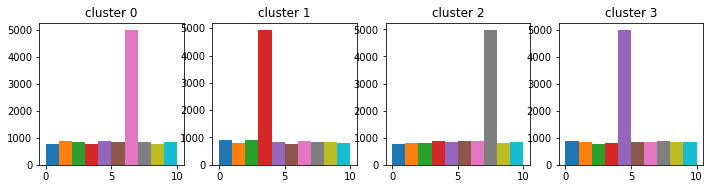

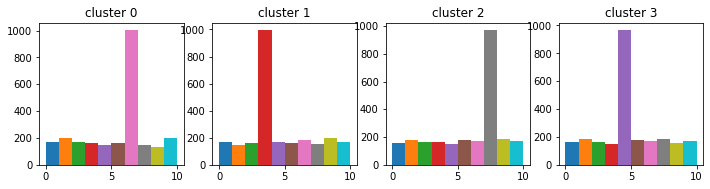

In [ ]:
f = plt.figure(figsize=(15, 12))
i = 0 # to plot
for cluster in range(number_of_clusters):
    cluster_ds = clusters_train_datasets[cluster]
    plot_data = collections.defaultdict(list)
    for el in cluster_ds['labels']:
        label = int(np.argmax(el))
        plot_data[label].append(label)
    plt.subplot(4, 5, i+1)
    i += 1
    plt.title('cluster ' + str(cluster))
    for j in range(10):
        plt.hist(plot_data[j], bins=range(11))

# plot test dataset histograms for clusters
f = plt.figure(figsize=(15, 12))
i = 0 # to plot
for cluster in range(number_of_clusters):
    cluster_ds = clusters_test_datasets[cluster]
    plot_data = collections.defaultdict(list)
    for el in cluster_ds['labels']:
        label = int(np.argmax(el))
        plot_data[label].append(label)
    plt.subplot(4, 5, i+1)
    i += 1
    plt.title('cluster ' + str(cluster))
    for j in range(10):
        plt.hist(plot_data[j], bins=range(11))

In [ ]:
# distribute the data among clusters
for i in range(len(clusters_train_datasets)):
    clusters[i].set_train_data(clusters_train_datasets[i])
    clusters[i].set_test_data(clusters_test_datasets[i])

In [ ]:
# divide the cluster dataset amoung users of the cluster, in a naive way...
for cluster in clusters:
    cluster_ds = cluster.train_data
    cluster_X = cluster_ds['images']
    cluster_Y = cluster_ds['labels']
    shuffler = np.random.permutation(len(cluster_X))
    cluster_X = cluster_X[shuffler]
    cluster_Y = cluster_Y[shuffler]
    size_of_user_ds = int(len(cluster_X) / cluster.number_of_users())
    for i in range(cluster.number_of_users()):
        X_user = cluster_X[size_of_user_ds*i:size_of_user_ds*i+size_of_user_ds]
        Y_user = cluster_Y[size_of_user_ds*i:size_of_user_ds*i+size_of_user_ds]
        user = cluster.users[i]
        user_data = collections.OrderedDict((('labels', Y_user), ('images', X_user)))
        user.set_data(user_data)

In [ ]:
# the server has got a model, randomly initalized, of the same 'shape' of the users single models
server_model = define_model()
initialize_models(clusters, server_model, classification_percentage/100) 

/usr/local/lib/python3.7/dist-packages/torch/distributions/distribution.py:46: UserWarning: <class '__main__.LogisticDistribution'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  'with `validate_args=False` to turn off validation.')


# CNN Training

In [ ]:
def train_user_model(user, cluster, epochs, batch):
    print('Training for user', user.name)
    user_model = user.get_model()
    X_test = cluster.test_data['images']
    Y_test = cluster.test_data['labels']
    _, accuracy = user_model.evaluate(X_test, Y_test)
    print('Test accuracy BEFORE training for user', user.name, 'of cluster', user.cluster, 'is', accuracy)
    user_data = user.data
    X_train_u = user_data['images']
    Y_train_u = user_data['labels']
    shuffler = np.random.permutation(len(X_train_u))
    X_train_u = X_train_u[shuffler]
    Y_train_u = Y_train_u[shuffler]     
    X_train_u, Y_train_u, X_validation_u, Y_validation_u = train_validation_split(X_train_u, Y_train_u)
    history = user_model.fit(X_train_u, Y_train_u, epochs=epochs, batch_size=batch, verbose=0, validation_data=(X_validation_u, Y_validation_u))
    _, accuracy = user_model.evaluate(X_test, Y_test)
    #summarize_diagnostics(history)
    user.set_model(user_model)
    user.set_accuracy(accuracy) # maybe useless
    print('Test accuracy AFTER training for user', user.name, 'of cluster', user.cluster, 'is', user.get_accuracy())

In [ ]:
# here there is NO parallelization, I train one CNN at a time (and one cluster at a time), in an iterative way

for _ in range(iterations):
    print('')
    print("************ Iteration " + str(_) + " ************")
    print("Sparsification = " + str(classification_percentage) + "%")
    print('')
    for cluster in clusters:
        cluster.model.save("/content/drive/MyDrive/Colab Notebooks/cluster"+str(cluster.number)+"_"+str(classification_percentage)+"sparse_iter"+str(_)+".h5")

        transfer_cluster_model_to_users(cluster) 
        # useless at first iteration but fundamental then 
        # not sparsified! Only in the uplink

        for user in cluster.users:
            train_user_model(user, cluster, epochs, batch)
            user.get_model().save("user"+str(user.name)+"_"+str(classification_percentage)+"sparse_iter"+str(_)+".h5")
            # so it saves the users in the volatile space of the colab, and the clusters (the most important model files) in the drive folder!

        print('Start aggregating cluster', cluster.number, 'parameters...')
        # aggregate
        cluster_trainset_size = len(cluster.train_data['images'])
        wc = cluster.model.get_weights()
        sum_terms = []
        for user in cluster.users:
            wu = user.get_model().get_weights()
            nu = len(user.data['labels'])
            frac = nu/cluster_trainset_size
            sum_terms.append([frac*np.subtract(wu[i], wc[i]) for i in range(len(wu))])
        update = sum_terms[0]
        for i in range(1, len(sum_terms)): # could do better...
            tmp = sum_terms[i]
            update = [np.add(tmp[j], update[j]) for j in range(len(update))]
        new_cluster_weights = [np.add(wc[i], update[i]) for i in range(len(wc))]
        sparse_weights = top_k_sparsificate_model_weights_tf(new_cluster_weights, classification_percentage/100)
        cluster.model.set_weights(sparse_weights)
        print('Updated model of cluster', cluster.number)
        print('')


************ Iteration 0 ************
Sparsification = 20%

Training for user 10
79/79 [==============================] - 2s 17ms/step - loss: 2.3183 - accuracy: 0.2937
Test accuracy BEFORE training for user 10 of cluster 0 is 0.29159998893737793
79/79 [==============================] - 2s 17ms/step - loss: 1.4957 - accuracy: 0.6420
Test accuracy AFTER training for user 10 of cluster 0 is 0.6420000195503235
Training for user 0
79/79 [==============================] - 2s 17ms/step - loss: 2.3183 - accuracy: 0.2937
Test accuracy BEFORE training for user 0 of cluster 0 is 0.29159998893737793
79/79 [==============================] - 2s 16ms/step - loss: 1.3773 - accuracy: 0.6868
Test accuracy AFTER training for user 0 of cluster 0 is 0.6868000030517578
Training for user 4
79/79 [==============================] - 2s 17ms/step - loss: 2.3183 - accuracy: 0.2937
Test accuracy BEFORE training for user 4 of cluster 0 is 0.29159998893737793
79/79 [==============================] - 2s 17ms/step -

## CNN Local evaluation

Evaluating performances of iteration number 0
79/79 [==============================] - 2s 17ms/step - loss: 2.0144 - accuracy: 0.3116
Evaluating performances of iteration number 1
79/79 [==============================] - 2s 17ms/step - loss: 1.9113 - accuracy: 0.4396
Evaluating performances of iteration number 2
79/79 [==============================] - 2s 17ms/step - loss: 2.4057 - accuracy: 0.4124
Evaluating performances of iteration number 3
79/79 [==============================] - 2s 17ms/step - loss: 2.6861 - accuracy: 0.4016
Evaluating performances of iteration number 4
79/79 [==============================] - 2s 17ms/step - loss: 2.9724 - accuracy: 0.3944


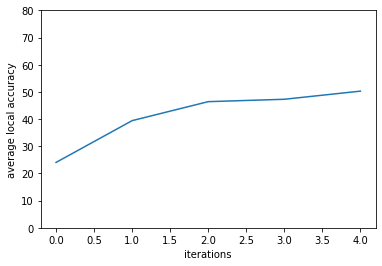

In [ ]:
# plot training performances
# Note: when a session expires all the saved models are deleted
average_local_accuracies = []
for i in range(iterations):
    print('Evaluating performances of iteration number', i)
    s = 0
    for cluster in clusters:
        X_test = cluster.test_data['images']
        Y_test = cluster.test_data['labels']
        tmp_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/cluster"+str(cluster.number)+"_"+str(classification_percentage)+"sparse_iter"+str(i)+".h5")
        _, accuracy = tmp_model.evaluate(X_test, Y_test)
        s += accuracy
    average_local_accuracies.append(s/len(clusters)*100)
plt.plot(range(iterations), average_local_accuracies)
plt.xlabel('iterations')
plt.ylabel('average local accuracy')
plt.ylim((0, 80))
name = str(classification_percentage) + "-sparse_local_CNN.png"
plt.savefig(name)

# NICE Training

In [ ]:
def train_estimation(model, epochs, dataloader):
    model.train()
    opt = optim.Adam(model.parameters())
    for i in range(epochs):
        mean_likelihood = 0.0
        num_minibatches = 0

        for batch_id, x in enumerate(dataloader):
            x = x.view(-1, 3072) + torch.rand(3072) / 256.
            x = torch.clamp(x, 0, 1) # serve per limitare 
            z, likelihood = model(x.float()) # ho messo .float() perche mi dava qualche problema
            #print(likelihood)
            loss = -torch.mean(likelihood) # NLL
            loss.backward()
            opt.step()
            model.zero_grad()
            mean_likelihood -= loss
            num_minibatches += 1

        mean_likelihood /= num_minibatches
        print('Epoch {} completed. Log Likelihood: {}'.format(i, mean_likelihood))  

In [ ]:
for _ in range(iterations):
    print('')
    print("************ Iteration " + str(_) + " ************")
    print('')
    for cluster in clusters:

        torch.save(cluster.estimation.state_dict(), "/content/drive/MyDrive/Colab Notebooks/estimation_cluster"+str(cluster.number)+"sparse_"+str(estimation_percentage)+"_iter"+str(_)+".pt")
        transfer_cluster_estimation_to_users(cluster)

        for user in cluster.users:
            # train the model ONLY on X_train
            dataloader = torch.utils.data.DataLoader(dataset=user.data['images'], batch_size=estimation_batch, shuffle=True, pin_memory=True)
            train_estimation(user.get_estimation(), estimation_epochs, dataloader)
            torch.save(user.get_estimation().state_dict(), "/content/drive/MyDrive/Colab Notebooks/estimation_user"+str(user.name)+"sparse"+str(estimation_percentage)+"_iter"+str(_)+".pt")

        print('Start aggregating cluster', cluster.number, 'estimation parameters...')
        # aggregate
        cluster_trainset_size = len(cluster.train_data['images'])
        sum_terms = []
        for user in cluster.users:
            pu = user.get_estimation().state_dict()
            nu = len(user.data['labels'])
            frac = nu/cluster_trainset_size
            for i in iter(pu):
                pu[i] = pu[i]*frac
            sum_terms.append(pu)
        ref = sum_terms[0]
        for i in iter(ref):
            for j in sum_terms[1:]:
                ref[i] += j[i]
        cluster.estimation.load_state_dict(topk_sparsification_torch_load(ref, estimation_percentage))
        print('Setted estimation of cluster', cluster.number)

Output streaming troncato alle ultime 5000 righe.
Epoch 152 completed. Log Likelihood: 2279.24267578125
Epoch 153 completed. Log Likelihood: 2286.968017578125
Epoch 154 completed. Log Likelihood: 1113.580810546875
Epoch 155 completed. Log Likelihood: 1167.4990234375
Epoch 156 completed. Log Likelihood: 1985.1357421875
Epoch 157 completed. Log Likelihood: 2180.564208984375
Epoch 158 completed. Log Likelihood: 2229.663330078125
Epoch 159 completed. Log Likelihood: 2260.324462890625
Epoch 160 completed. Log Likelihood: 2280.705078125
Epoch 161 completed. Log Likelihood: 2295.046875
Epoch 162 completed. Log Likelihood: 2307.86474609375
Epoch 163 completed. Log Likelihood: 2320.823974609375
Epoch 164 completed. Log Likelihood: 2329.25146484375
Epoch 165 completed. Log Likelihood: 2338.01318359375
Epoch 166 completed. Log Likelihood: 2344.508544921875
Epoch 167 completed. Log Likelihood: 2354.831787109375
Epoch 168 completed. Log Likelihood: 2363.04443359375
Epoch 169 completed. Log Likeliho

# I can make the training independent for each cluster in order to avoid conflicts

# Test before 2-nd March

Test the 50-sparse classification + 100-sparse estimation model

************ Iteration 0 ************



/usr/local/lib/python3.7/dist-packages/torch/distributions/distribution.py:46: UserWarning: <class '__main__.LogisticDistribution'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  'with `validate_args=False` to turn off validation.')


hybrid accuracy: 23.69
CNN accuracy: 50.39

************ Iteration 1 ************

hybrid accuracy: 58.050000000000004
CNN accuracy: 61.019999999999996

************ Iteration 2 ************

hybrid accuracy: 61.7
CNN accuracy: 61.95

************ Iteration 3 ************

hybrid accuracy: 60.97
CNN accuracy: 62.25000000000001

************ Iteration 4 ************

hybrid accuracy: 59.34
CNN accuracy: 60.01


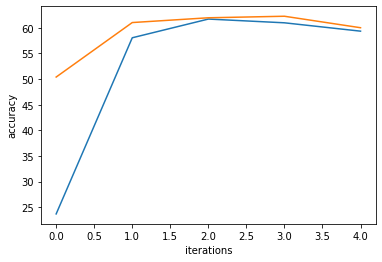

In [ ]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
num_classes = len(classes)
X_test = X_test.astype('float32') / 255.0
Y_test = to_categorical(Y_test, num_classes)

print("Test the " + str(classification_percentage)+"-sparse classification + "+str(estimation_percentage)+"-sparse estimation model")

hybrid_model_acc = []
only_CNN_acc = []

for _ in range(iterations):
    
    print('')
    print("************ Iteration " + str(_) + " ************")
    print('')

    true_pred_from_hybrid_model = 0
    true_pred_from_only_CNN = 0
    
    # import all the models at the beginning of the iteration to save time
    classification_models = [tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/old heterogeneity/classification"+str(classification_percentage)+"/cluster"+
                                                        str(cluster.number)+"_"+str(classification_percentage)+"sparse_iter"+
                                                        str(_)+".h5") for cluster in clusters]
    estimation_models = []
    for cluster in clusters:
        # it is necessary to define AND THEN fill the model, in PyTorch (I think)
        tmp_model = NICE(data_dim=3072, num_coupling_layers=3)
        tmp_model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/old heterogeneity/estimation"+str(estimation_percentage)+"/estimation_cluster"+
                                             str(cluster.number)+"sparse_"+str(estimation_percentage)+"_iter"+str(_)+".pt"))
        estimation_models.append(tmp_model)

    eval_images = len(X_test)
    for t in range(eval_images):

        # often there are some troubles with the test set...
        if not len(X_test) == 10000:
            print("ERROR")
            break

        test_img = X_test[t]
        test_label = Y_test[t]
        true = np.argmax(test_label)
        
        prediction_vectors = []
        log_probs = []
        for cluster in range(len(clusters)):
            tmp_model = classification_models[cluster]
            tmp_est = estimation_models[cluster]
            log_prob = tmp_est.forward(torch.from_numpy(test_img.reshape((3072))).float())[1]-tmp_est.f(torch.from_numpy(test_img.reshape((3072))).float())[1]
            log_probs.append(log_prob.detach().numpy().reshape((-1)))
            pred = tmp_model.predict(test_img.reshape((1, 32, 32, 3)))
            prediction_vectors.append(pred.reshape(-1))
        
        if np.argmax(sum(prediction_vectors)) == true:
            true_pred_from_only_CNN += 1
        
        ''' 
        # what I used to do for hybrid models, it is more clear
        a = float(max(log_probs))
        log_meno_a = [float(el-a) for el in log_probs]
        sum_exp = 0
        for el in log_meno_a:
            sum_exp += np.exp(el)
        comp = a+np.log(sum_exp)
        alpha = [np.exp(el-comp) for el in log_probs]
        
        final_vector = [alpha[i]*prediction_vectors[i] for i in range(len(clusters))]
        predicted = np.argmax(sum(final_vector))
        '''
        
        # original
        comp = float(max(log_probs)) + np.log(sum(np.exp([float(el-float(max(log_probs))) for el in log_probs])))
        alpha = [np.exp(el-comp) for el in log_probs]
        predicted = np.argmax(sum([alpha[i]*prediction_vectors[i] for i in range(len(clusters))]))
        if predicted == true:
            true_pred_from_hybrid_model += 1
        
    hybrid_accuracy = true_pred_from_hybrid_model/eval_images*100
    only_CNN_accuracy = true_pred_from_only_CNN/eval_images*100
    
    print('hybrid accuracy:', hybrid_accuracy)
    print('CNN accuracy:', only_CNN_accuracy)

    hybrid_model_acc.append(hybrid_accuracy)
    only_CNN_acc.append(only_CNN_accuracy)
  
plt.plot(range(iterations), hybrid_model_acc)
plt.plot(range(iterations), only_CNN_acc)
plt.xlabel('iterations')
plt.ylabel('accuracy')
name = "Test_" + str(classification_percentage) + "-" + str(estimation_percentage) + "_model.png" 
plt.savefig(name)

In [ ]:
''' Example of output:
Test the 100-sparse classification + 50-sparse estimation model

************ Iteration 0 ************

WARNING:tensorflow:5 out of the last 21277 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f3b884e2320> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
WARNING:tensorflow:5 out of the last 21277 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f3b884e2320> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
hybrid accuracy: 26.77
CNN accuracy: 54.67999999999999
idea 1 accuracy: 51.07000000000001
idea 2 accuracy: 51.92

************ Iteration 1 ************

WARNING:tensorflow:5 out of the last 40001 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f3b84ca78c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
WARNING:tensorflow:5 out of the last 40001 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f3b84ca78c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
hybrid accuracy: 71.54
CNN accuracy: 73.5
idea 1 accuracy: 74.0
idea 2 accuracy: 71.67

************ Iteration 2 ************

WARNING:tensorflow:5 out of the last 40001 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f3b86942950> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
WARNING:tensorflow:5 out of the last 40001 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f3b86942950> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
hybrid accuracy: 74.72
CNN accuracy: 77.01
idea 1 accuracy: 77.17
idea 2 accuracy: 75.32

************ Iteration 3 ************

WARNING:tensorflow:5 out of the last 40001 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f3b83c16440> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
WARNING:tensorflow:5 out of the last 40001 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f3b83c16440> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
hybrid accuracy: 76.13
CNN accuracy: 79.34
idea 1 accuracy: 79.44
idea 2 accuracy: 77.84

************ Iteration 4 ************

WARNING:tensorflow:5 out of the last 40001 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f3b88b96dd0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
WARNING:tensorflow:5 out of the last 40001 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f3b88b96dd0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
hybrid accuracy: 77.42
CNN accuracy: 79.82000000000001
idea 1 accuracy: 79.96
idea 2 accuracy: 78.41
'''

# Output of test of 9-th March

In [ ]:
'''
Test the 50-sparse classification + 100-sparse estimation model

************ Iteration 0 ************

Averaging only CNNs = 50.39
Averaging only CNNs without bias = 35.54631674678446
Hybrid model without bias = 10.98798553598507
Hybrid model = 23.69

************ Iteration 1 ************

Averaging only CNNs = 61.019999999999996
Averaging only CNNs without bias = 48.18556426957331
Hybrid model without bias = 45.77300930713547
Hybrid model = 58.050000000000004

************ Iteration 2 ************

Averaging only CNNs = 61.95
Averaging only CNNs without bias = 50.124524839428496
Hybrid model without bias = 49.68470835522859
Hybrid model = 61.7

************ Iteration 3 ************

Averaging only CNNs = 62.25000000000001
Averaging only CNNs without bias = 49.94032621668214
Hybrid model without bias = 48.63797868140545
Hybrid model = 60.97

************ Iteration 4 ************

Averaging only CNNs = 60.01
Averaging only CNNs without bias = 47.68445839874411
Hybrid model without bias = 46.24537281861449
Hybrid model = 59.34
'''

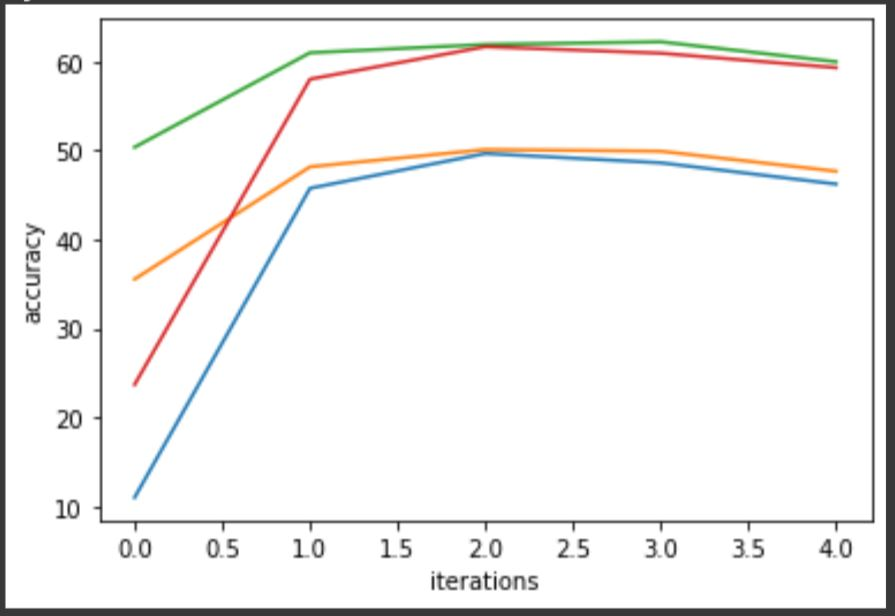

# Test 16-th March

In [ ]:
print("Test the " + str(classification_percentage)+"-sparse classification + "+str(estimation_percentage)+"-sparse estimation model")

only_cnn = []
hybrid = []

for _ in range(1, iterations):
    print("\n************ Iteration " + str(_) + " ************\n")

    true_only_cnn = 0
    true_hybrid = 0

    classification_models = [tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/classification"+str(classification_percentage)+"/cluster"+
                                                        str(cluster.number)+"_"+str(classification_percentage)+"sparse_iter"+
                                                        str(_)+".h5") for cluster in clusters]
    estimation_models = []
    for cluster in clusters:
        tmp_model = NICE(data_dim=3072, num_coupling_layers=3)
        tmp_model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/estimation"+str(estimation_percentage)+"/estimation_cluster"+str(cluster.number)+"sparse_"+str(estimation_percentage)+"_iter"+str(_)+".pt"))
        estimation_models.append(tmp_model)

    eval_images = 5000 #len(X_test)

    for t in range(eval_images):
        test_img = X_test[t]
        true = np.argmax(Y_test[t])
        
        prediction_vectors = []
        log_probs = []
        for cluster in range(len(clusters)):
            tmp_model = classification_models[cluster]
            tmp_est = estimation_models[cluster]
            log_prob = tmp_est.forward(torch.from_numpy(test_img.reshape((3072))).float())[1]-tmp_est.f(torch.from_numpy(test_img.reshape((3072))).float())[1]
            log_probs.append(log_prob.detach().numpy().reshape((-1)))
            pred = tmp_model.predict(test_img.reshape((1, 32, 32, 3)))
            prediction_vectors.append(pred.reshape(-1))
        
        if np.argmax(sum(prediction_vectors)) == true:
            true_only_cnn += 1
            true_hybrid += 1

        else:
            comp = float(max(log_probs)) + np.log(sum(np.exp([float(el-float(max(log_probs))) for el in log_probs])))
            alpha = [np.exp(el-comp) for el in log_probs]
            predicted = np.argmax(sum([alpha[i]*prediction_vectors[i] for i in range(len(clusters))]))

            if predicted == true:
                true_hybrid += 1


    only_cnn_acc = true_only_cnn / eval_images * 100
    hybrid_acc = true_hybrid / eval_images * 100
    print('Averaging only CNNs =', only_cnn_acc) 
    print('Hybrid model =', hybrid_acc)
    only_cnn.append(only_cnn_acc)
    hybrid.append(hybrid_acc)

plt.plot(range(iterations), only_cnn)
plt.plot(range(iterations), hybrid)
plt.xlabel('iterations')
plt.ylabel('accuracy')
name = "Test_" + str(classification_percentage) + "-" + str(estimation_percentage) + "_model.png" 
plt.savefig(name)

In [ ]:
'''
Test the 50-sparse classification + 100-sparse estimation model

************ Iteration 1 ************
Averaging only CNNs = 61.44
Hybrid model = 65.72
match of the flow on the overall computation = 0.0

************ Iteration 2 ************
Averaging only CNNs = 62.18
Hybrid model = 67.84
match of the flow on the overall computation = 0.0

************ Iteration 3 ************
Averaging only CNNs = 62.5
Hybrid model = 66.02

************ Iteration 4 ************
Averaging only CNNs = 60.4
Hybrid model = 65.08

CONCLUSIONS: increase the accuracy of the normalizing flow!!
'''

# Match of the flow. [solved]

In [ ]:
print("Estimation model with " + str(estimation_percentage) + " sparsification.")

for _ in range(iterations):
    print("\n************ Iteration " + str(_) + " ************")

    match = 0
    check = 0

    estimation_models = []
    for cluster in clusters:
        tmp_model = NICE(data_dim=3072, num_coupling_layers=3)
        tmp_model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/estimation"+str(estimation_percentage)+"/estimation_cluster"+str(cluster.number)+"sparse_"+str(estimation_percentage)+"_iter"+str(_)+".pt"))
        estimation_models.append(tmp_model)

    eval_images = len(X_test)

    for t in range(eval_images):
        test_img = X_test[t]
        true = np.argmax(Y_test[t])

        if true in fav_classes:
            check += 1
            prediction_vectors = []
            log_probs = []

            for cluster in range(len(clusters)):
                #tmp_model = classification_models[cluster]
                tmp_est = estimation_models[cluster]
                log_prob = tmp_est.forward(torch.from_numpy(test_img.reshape((3072))).float())[1]-tmp_est.f(torch.from_numpy(test_img.reshape((3072))).float())[1]
                log_probs.append(log_prob.detach().numpy().reshape((-1)))
                #pred = tmp_model.predict(test_img.reshape((1, 32, 32, 3)))
                #prediction_vectors.append(pred.reshape(-1))
            
            comp = float(max(log_probs)) + np.log(sum(np.exp([float(el-float(max(log_probs))) for el in log_probs])))
            alpha = [np.exp(el-comp) for el in log_probs]
            if fav_classes[np.argmax(alpha)] == true:
                match += 1
    print("Match of the normalizing flow = " + str(match/check*100))

In [ ]:
'''
Estimation model with 100 sparsification.

************ Iteration 0 ************
/usr/local/lib/python3.7/dist-packages/torch/distributions/distribution.py:46: UserWarning: <class '__main__.LogisticDistribution'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  'with `validate_args=False` to turn off validation.')
Match of the normalizing flow = 24.099999999999998

************ Iteration 1 ************
Match of the normalizing flow = 27.500000000000004

************ Iteration 2 ************
Match of the normalizing flow = 30.375000000000004

************ Iteration 3 ************
Match of the normalizing flow = 34.025

************ Iteration 4 ************
Match of the normalizing flow = 32.2

CONCLUSIONS: increase the accuracy of the normalizing flow!!

# Test how NN works for different clusters and some images

In [ ]:
print("Test the " + str(classification_percentage)+"-sparse classification + "+str(estimation_percentage)+"-sparse estimation model\n")


for _ in range(iterations-1, iterations): # since the output is huge, I compute it only for the last iteration
    classification_models = [tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/old heterogeneity/classification"+str(classification_percentage)+"/cluster"+
                                                        str(cluster.number)+"_"+str(classification_percentage)+"sparse_iter"+
                                                        str(_)+".h5") for cluster in clusters]

    eval_images = 45 #len(X_test)

    for t in range(eval_images):
        test_img = X_test[t]
        true = np.argmax(Y_test[t])
        print("\n\n******** Image number " + str(t) + " of the test set. Label: " + str(true) + " ********")

        if true in fav_classes:
            print("(This is in fav_classes, so one cluster has to be strongly sure about its prediction!)\n")
        
        prediction_vectors = []
        #log_probs = []
        for cluster in range(len(clusters)):
            tmp_model = classification_models[cluster]
            #tmp_est = estimation_models[cluster]
            #log_prob = tmp_est.forward(torch.from_numpy(test_img.reshape((3072))).float())[1]-tmp_est.f(torch.from_numpy(test_img.reshape((3072))).float())[1]
            #log_probs.append(log_prob.detach().numpy().reshape((-1)))
            pred = tmp_model.predict(np.expand_dims(test_img, axis=0)).reshape(-1)
            print(str(cluster) +") Softmax of cnn of cluster " + str(cluster) + " is ", end='')
            s = ""
            for el in pred:
                s += str("%.2f" % el) + ", "
            print("[" + s[:len(s)-2] + "]", end='')
            print(", prediction = " + str(np.argmax(pred)))
            prediction_vectors.append(pred)
        
        if np.argmax(sum(prediction_vectors)) == true:
            print("(In this case the average prediction is right.)")

# Test if a biased CNN is preferable over the others on its most frequent label. [solved]

In [ ]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
num_classes = len(classes)
X_test = X_test.astype('float32') / 255.0
Y_test = to_categorical(Y_test, num_classes)

for _ in range(iterations):
    print("\n\n*** Iteration " + str(_))
    classification_models = [tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/old heterogeneity/classification"+str(classification_percentage)+"/cluster"+
                                                        str(cluster.number)+"_"+str(classification_percentage)+"sparse_iter"+
                                                        str(_)+".h5") for cluster in clusters]

    cluster_accuracies = [0, 0, 0, 0]
    cluster_check = [0, 0, 0, 0]
    eval_images = len(X_test)

    for t in range(eval_images):

        # often there are some troubles with the test set...
        if not len(X_test) == 10000:
            print("ERROR")
            break

        test_img = X_test[t]
        true = np.argmax(Y_test[t])

        if true in fav_classes:

            #print("\n Image number " + str(t) + " of the test set. Label: " + str(true))
            #print("Model of the cluster "+ str(fav_classes.index(true)) + " is taken into account.")

            cluster_check[fav_classes.index(true)] += 1

            tmp_model = classification_models[fav_classes.index(true)]
            pred = tmp_model.predict(np.expand_dims(test_img, axis=0)).reshape(-1)
            #print("softmax: ", end='')
            s = ""
            for el in pred:
                s += str("%.2f" % el) + ", "
            #print("[" + s[:len(s)-2] + "]", end='')
            #print(", prediction = " + str(np.argmax(pred)))

            if np.argmax(pred) == true:
                cluster_accuracies[fav_classes.index(true)] += 1
                #print("Correct!")
            #else:
                #print("Wrong")

    print("\nLocal partial cluster accuracies are:")
    for _ in range(4):
        if cluster_check[_] == 0:
            if cluster_accuracies[_] == 0:
                acc = "NaN"
        else:
            acc = cluster_accuracies[_]/cluster_check[_]*100
        print(str(_) + ") for cluster number " + str(_) +": " + str(acc))



In [ ]:
'''
*** Iteration 0

Local partial cluster accuracies are:
0) for cluster number 0: 71.8
1) for cluster number 1: 0.1
2) for cluster number 2: 66.0
3) for cluster number 3: 20.0


*** Iteration 1

Local partial cluster accuracies are:
0) for cluster number 0: 71.6
1) for cluster number 1: 20.0
2) for cluster number 2: 72.6
3) for cluster number 3: 7.7


*** Iteration 2

Local partial cluster accuracies are:
0) for cluster number 0: 60.6
1) for cluster number 1: 35.0
2) for cluster number 2: 83.7
3) for cluster number 3: 10.100000000000001


*** Iteration 3

Local partial cluster accuracies are:
0) for cluster number 0: 70.7
1) for cluster number 1: 28.599999999999998
2) for cluster number 2: 86.5
3) for cluster number 3: 12.9


*** Iteration 4

Local partial cluster accuracies are:
0) for cluster number 0: 65.10000000000001
1) for cluster number 1: 32.6
2) for cluster number 2: 86.1
3) for cluster number 3: 10.7

CONCLUSION: the CNNs are not so accurate, even in their favourite images !!!
'''

# Notes


- change the setup (i.e. increase or simply change the heterogeneity)
- try with different sparsification (train networks with high sparsification!)
- try to use ONLY the flow, that decides which NN gives the results